<a href="https://colab.research.google.com/github/stebechoi/CP2/blob/Hwkdir/1.%20(MovieLense100K)_%EC%A0%84%EC%B2%98%EB%A6%AC_%EB%B0%8F_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MovieLense 데이터를 이용한 영화 추천 시스템 (전처리 & EDA)

## 정보
- 활용 데이터: MovieLense 100k
- 출처: https://grouplens.org/datasets/movielens/100k/ 

### 데이터 로드

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')
# 작업 디렉토리 변경 change directory
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/CP/CP2')

Mounted at /content/gdrive


In [2]:
# 현재 작업중인 위치 current working directory
os.getcwd()

'/content/gdrive/MyDrive/Colab Notebooks/CP/CP2'

In [ ]:
ls

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### 파일 확인
- readme.text 확인하여 각 컬럼명 할당
1. u.data / 유저별 영화평점
2. u.item / 영화 정보
3. u.info / 고객 수, 영화 수, 평점 수
4. u.genres / 장르목록
5. u.user / id, 나이, 성별, 직업, 우편번호
6. u.occupation / 직업목록

In [68]:
# 01. u.data 파일. 각 유저별 각 영화평점
columns=['user_id', 'movie_id', 'rating', 'timestamp'] # 정의서에는 item id로 되어 있으나 item파일과의 통일성 위해 movie id로 로드
data=pd.read_csv('ml-100k/u.data', sep='\t', names=columns)
# 타임스탬프 변환
from datetime import datetime
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s') #Thanks to RecSys02 # unit='s'의 의미? (s=second 초단위/ D,s,ms,us,ns)

# 02. u.item 파일. 영화정보(출시일, 이미지url(IMDB), 장르 원핫인코딩) 
column_names = ['movie_id', 'movie_title', 'release_date', 'video_release_date',
              'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 
              "Children's", "Comedy", 'Crime', 'Documentary', 'Drama', 'Fantasy', 
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
              'Thriller', 'War', 'Western']
movies = pd.read_csv('ml-100k/u.item', encoding='latin-1', sep='\|', header=None, index_col=0, names=column_names ) 
# index_col=0, CF예시에서는 인덱스를 생략하고 movie id를 인덱스로 쓰는데, 그럴 경우 merge하면서 컬럼 불러오기가 안된다.

# 03. u.info 파일. 전체 유저 수, 전체 영화 수 , 전체 평점 수
info = pd.read_csv('ml-100k/u.info', header=None)

# 04. u.genre 파일. 장르의 이름과 id 매치
genre = pd.read_csv('ml-100k/u.genre', sep='|', names=['genre','g_id'])

# 05. u.user 파일. 평점자 정보(id, 나이, 성별, 직업, 우편번호)
column_names2 = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
user=pd.read_csv('ml-100k/u.user', sep='|', names = column_names2)

# 06. u.occupation 파일. 직업과 숫자 매칭
occu=pd.read_csv('ml-100k/u.occupation', header=None, names=['occupations'])

<ipython-input-68-8756d865a046>:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('ml-100k/u.item', encoding='latin-1', sep='\|', header=None, index_col=0, names=column_names )


In [69]:
for all in [data, movies, user]:
  print(all.head())
  print("+"*8)

print('='*8)

print(info)
print('='*8)
print(genre)
print('='*8)
print(occu)

   user_id  movie_id  rating           timestamp
0      196       242       3 1997-12-04 15:55:49
1      186       302       3 1998-04-04 19:22:22
2       22       377       1 1997-11-07 07:18:36
3      244        51       2 1997-11-27 05:02:03
4      166       346       1 1998-02-02 05:33:16
++++++++
                movie_title release_date  video_release_date  \
movie_id                                                       
1          Toy Story (1995)  01-Jan-1995                 NaN   
2          GoldenEye (1995)  01-Jan-1995                 NaN   
3         Four Rooms (1995)  01-Jan-1995                 NaN   
4         Get Shorty (1995)  01-Jan-1995                 NaN   
5            Copycat (1995)  01-Jan-1995                 NaN   

                                                   IMDb_URL  unknown  Action  \
movie_id                                                                       
1         http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
2       

### 데이터 정제

In [70]:
# 평점 점수 범위 확인 및 이상한 점수 확인
data.rating.unique()

array([3, 1, 2, 4, 5])

In [23]:
# data null값 확인, 없음
data.isna().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

In [24]:
# movies null 값 확인
movies.isna().sum()

movie_title              0
release_date             1
video_release_date    1682
IMDb_URL                 3
unknown                  0
Action                   0
Adventure                0
Animation                0
Children's               0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
dtype: int64

In [72]:
# 1682개 전부가 null인 video_release_date 드롭
movies.drop(['video_release_date'], axis=1, inplace=True)

In [26]:
# release_date 항목에서 null 값을 가진 한 개의 row 탐색
movies[movies['release_date'].isna()]
# 영화제목도, 장르도 unknown. 제목이 unknown?, 아니면 missing값?

,movie_title,release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
267,unknown,NaN,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# movie_id가 267인 영화 rating 탐색
data[data['movie_id']==267]

,user_id,movie_id,rating,timestamp
2172,130,267,5,1997-10-02 14:07:19
3781,5,267,4,1997-09-30 15:57:44
7245,268,267,3,1997-10-01 21:41:17
12475,297,267,3,1997-09-28 01:12:19
14756,319,267,4,1997-10-01 12:08:10
15292,1,267,4,1997-10-01 08:02:35
49295,532,267,3,1997-09-28 10:09:08
93523,833,267,1,1997-09-30 21:41:09
99723,422,267,4,1997-09-30 21:46:26


In [73]:
# movie_id 267 정보 삭제
print(movies.shape)
mv_drop = movies.drop(index=267)
print(mv_drop.shape)

(1682, 22)
(1681, 22)


In [74]:
# 이미지 링크 삭제
tng= mv_drop.drop(['IMDb_URL'], axis=1)
tng.head() #title and genre

,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [30]:
movies.duplicated(['movie_title'])

movie_id
1       False
2       False
3       False
4       False
5       False
        ...  
1678    False
1679    False
1680     True
1681    False
1682    False
Length: 1682, dtype: bool

In [31]:
movies[movies.duplicated(['movie_title'])].sort_values(by='movie_title', ascending=True)
# 중복값이 있다고 나오지만, 실제로 중복된 값이 보이지는 않는다.

,movie_title,release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
670,Body Snatchers (1993),01-Jan-1993,http://us.imdb.com/M/title-exact?Body%20Snatch...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
1650,"Butcher Boy, The (1998)",01-Jan-1998,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1654,Chairman of the Board (1998),01-Jan-1998,http://us.imdb.com/Title?Chairman+of+the+Board...,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
268,Chasing Amy (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?Chasing+Amy+(...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1606,Deceiver (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?Liar+(1997),0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1257,"Designated Mourner, The (1997)",23-May-1997,http://us.imdb.com/M/title-exact?Designated%20...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
348,Desperate Measures (1998),30-Jan-1998,http://us.imdb.com/Title?Desperate+Measures+(1...,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
500,Fly Away Home (1996),13-Sep-1996,http://us.imdb.com/M/title-exact?Fly%20Away%20...,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1617,Hugo Pool (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?Hugo+Pool+(1997),0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [75]:
# movie_title이 unknown이었던 rating 삭제
data_drop = data.drop(data[data['movie_id']==267].index)

In [76]:
df = pd.merge(pd.merge(tng, data_drop, on='movie_id'), user, on='user_id')
df

,movie_id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Thriller,War,Western,user_id,rating,timestamp,age,gender,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,308,4,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,308,5,1998-02-17 17:51:30,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,1,0,0,308,4,1998-02-17 18:20:08,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,308,4,1998-02-17 18:07:27,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,0,0,0,0,1,1,0,...,0,0,0,308,5,1998-02-17 17:31:36,60,M,retired,95076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99986,748,"Saint, The (1997)",14-Mar-1997,0,1,0,0,0,0,0,...,1,0,0,729,4,1998-04-22 23:10:38,19,M,student,56567
99987,751,Tomorrow Never Dies (1997),01-Jan-1997,0,1,0,0,0,0,0,...,1,0,0,729,3,1998-04-22 23:05:38,19,M,student,56567
99988,879,"Peacemaker, The (1997)",01-Jan-1997,0,1,0,0,0,0,0,...,1,1,0,729,3,1998-04-22 23:04:59,19,M,student,56567
99989,894,Home Alone 3 (1997),01-Jan-1997,0,0,0,0,1,1,0,...,0,0,0,729,1,1998-04-22 23:08:31,19,M,student,56567


In [77]:
df.columns

Index(['movie_id', 'movie_title', 'release_date', 'unknown', 'Action',
       'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'user_id',
       'rating', 'timestamp', 'age', 'gender', 'occupation', 'zip_code'],
      dtype='object')

In [78]:
df_al = df.copy()

In [117]:
# release_date에서 연도와 월 분리
df_al['release_year'] = df_al['release_date'].str[-4:]
df_al['release_month'] = df_al['release_date'].str[-8:-5]

# month 숫자 변환
month = {
    'Jan' : '01',
    'Feb' : '02',
    'Mar' : '03',
    'Apr' : '04',
    'May' : '05',
    'Jun' : '06',
    'Jul' : '07',
    'Aug' : '08',
    'Sep' : '09',
    'Oct' : '10',
    'Nov' : '11',
    'Dec' : '12'}

df_al['rel_month_num'] = pd.Series([month[x] for x in df_al['release_month']])
df_al['release_month'] = df_al['rel_month_num']

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99991 entries, 0 to 99990
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   movie_id      99991 non-null  int64         
 1   movie_title   99991 non-null  object        
 2   release_date  99991 non-null  object        
 3   unknown       99991 non-null  int64         
 4   Action        99991 non-null  int64         
 5   Adventure     99991 non-null  int64         
 6   Animation     99991 non-null  int64         
 7   Children's    99991 non-null  int64         
 8   Comedy        99991 non-null  int64         
 9   Crime         99991 non-null  int64         
 10  Documentary   99991 non-null  int64         
 11  Drama         99991 non-null  int64         
 12  Fantasy       99991 non-null  int64         
 13  Film-Noir     99991 non-null  int64         
 14  Horror        99991 non-null  int64         
 15  Musical       99991 non-null  int64 

In [49]:
df['timestamp']

0       1998-02-17 17:28:52
1       1998-02-17 17:51:30
2       1998-02-17 18:20:08
3       1998-02-17 18:07:27
4       1998-02-17 17:31:36
                ...        
99986   1998-04-22 23:10:38
99987   1998-04-22 23:05:38
99988   1998-04-22 23:04:59
99989   1998-04-22 23:08:31
99990   1998-04-22 23:08:11
Name: timestamp, Length: 99991, dtype: datetime64[ns]

In [57]:
df['timestamp'].dt.year.value_counts()

1997    52890
1998    47101
Name: timestamp, dtype: int64

In [80]:
# timestamp에서 연도와 월 분리
df_al['rating_year'] = df_al['timestamp'].dt.year
df_al['rating_month'] = df_al['timestamp'].dt.month

In [65]:
df_al['age'].unique()

array([60, 21, 33, 30, 23, 29, 26, 31, 24, 32, 50, 17, 45, 20, 11, 19, 25,
       46, 38, 59, 61, 42, 28, 57, 27, 40, 35, 52, 51, 49, 22, 36, 53, 43,
       15, 48, 18, 44, 10, 39, 47, 41, 34, 37, 54, 63, 13, 14, 16, 58, 70,
        7, 55, 69, 73, 65, 56, 68, 66, 64, 62])

In [81]:
# 연령대 그룹핑
temp = []
for age in df_al.age:
  if age < 20 :
    a = 1
  elif age < 30 :
    a = 2
  elif age < 40 :
    a = 3
  elif age < 50 : 
    a = 4
  elif age < 60 :
    a = 5
  else: 
    a = 6
  temp.append(a)

df_al['age_group'] = temp

- 미국 zip code </br>
  참고: https://blog.naver.com/archeteras/222460921025

![zip code zone](https://search.pstatic.net/sunny/?src=https%3A%2F%2Fi.pinimg.com%2Foriginals%2F5a%2F96%2Fc4%2F5a96c4c00b54e2c2011a5decab88b14b.jpg&type=sc960_832)

![zip code states](https://search.pstatic.net/sunny/?src=https%3A%2F%2Fi.pinimg.com%2F736x%2F2c%2F7e%2F4d%2F2c7e4dee89456547081011f2a2135252--zip-code-map-usa-university.jpg&type=sc960_832)

In [ ]:
df_al['zip_code'].unique()

In [89]:
df_al['zip_code'].str[:1].value_counts()

9    18848
5    11759
2    10596
1    10329
0     9343
6     8942
4     7986
8     7441
7     6728
3     5933
V      488
E      460
N      455
L      193
Y      183
T      174
M       49
R       47
K       37
Name: zip_code, dtype: int64

In [99]:
# zip_code 기반 지역 그룹핑
# 알파벳으로 된 잘못 기입된 번호는 10으로 처리
df_al['region'] = df_al['zip_code'].str[:1].str.replace(r'[^0-9]', '10').value_counts()

<ipython-input-99-7a544a7f6225>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_al['region'] = df_al['zip_code'].str[:1].str.replace(r'[^0-9]', '10').value_counts()


In [118]:
df_al = df_al[['user_id', 'movie_id', 'movie_title', 'rating', 'release_date', 'release_year', 'release_month', 
         'timestamp', 'rating_year', 'rating_month', 'age', 'age_group', 'gender', 'occupation', 'zip_code', 'region',  
         'unknown', 'Action','Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
         'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
         'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 
       ]]
df_al

,user_id,movie_id,movie_title,rating,release_date,release_year,release_month,timestamp,rating_year,rating_month,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,308,1,Toy Story (1995),4,01-Jan-1995,1995,01,1998-02-17 17:28:52,1998,2,...,0,0,0,0,0,0,0,0,0,0
1,308,4,Get Shorty (1995),5,01-Jan-1995,1995,01,1998-02-17 17:51:30,1998,2,...,0,0,0,0,0,0,0,0,0,0
2,308,5,Copycat (1995),4,01-Jan-1995,1995,01,1998-02-17 18:20:08,1998,2,...,0,0,0,0,0,0,0,1,0,0
3,308,7,Twelve Monkeys (1995),4,01-Jan-1995,1995,01,1998-02-17 18:07:27,1998,2,...,0,0,0,0,0,0,1,0,0,0
4,308,8,Babe (1995),5,01-Jan-1995,1995,01,1998-02-17 17:31:36,1998,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99986,729,748,"Saint, The (1997)",4,14-Mar-1997,1997,03,1998-04-22 23:10:38,1998,4,...,0,0,0,0,0,1,0,1,0,0
99987,729,751,Tomorrow Never Dies (1997),3,01-Jan-1997,1997,01,1998-04-22 23:05:38,1998,4,...,0,0,0,0,0,1,0,1,0,0
99988,729,879,"Peacemaker, The (1997)",3,01-Jan-1997,1997,01,1998-04-22 23:04:59,1998,4,...,0,0,0,0,0,0,0,1,1,0
99989,729,894,Home Alone 3 (1997),1,01-Jan-1997,1997,01,1998-04-22 23:08:31,1998,4,...,0,0,0,0,0,0,0,0,0,0


In [119]:
# 전처리 파일 저장
# df_al.to_csv('movielense_merged.csv', index=False)

In [120]:
df_us = df_al[['user_id', 'movie_id', 'movie_title', 'rating', 'release_year', 'release_month', 
         'rating_year', 'rating_month', 'age_group', 'gender', 'occupation', 'region',  
         'unknown', 'Action','Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
         'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
         'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 
       ]]
df_us

,user_id,movie_id,movie_title,rating,release_year,release_month,rating_year,rating_month,age_group,gender,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,308,1,Toy Story (1995),4,1995,01,1998,2,6,M,...,0,0,0,0,0,0,0,0,0,0
1,308,4,Get Shorty (1995),5,1995,01,1998,2,6,M,...,0,0,0,0,0,0,0,0,0,0
2,308,5,Copycat (1995),4,1995,01,1998,2,6,M,...,0,0,0,0,0,0,0,1,0,0
3,308,7,Twelve Monkeys (1995),4,1995,01,1998,2,6,M,...,0,0,0,0,0,0,1,0,0,0
4,308,8,Babe (1995),5,1995,01,1998,2,6,M,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99986,729,748,"Saint, The (1997)",4,1997,03,1998,4,1,M,...,0,0,0,0,0,1,0,1,0,0
99987,729,751,Tomorrow Never Dies (1997),3,1997,01,1998,4,1,M,...,0,0,0,0,0,1,0,1,0,0
99988,729,879,"Peacemaker, The (1997)",3,1997,01,1998,4,1,M,...,0,0,0,0,0,0,0,1,1,0
99989,729,894,Home Alone 3 (1997),1,1997,01,1998,4,1,M,...,0,0,0,0,0,0,0,0,0,0


### 탐색적 데이터 분석(EDA)
- 참고: </br>
  https://www.kaggle.com/code/arushikhokharr/a-beginner-s-guide-to-recommendation-systems </br>
  https://www.youtube.com/watch?v=8kElv1sticI 

#### 최빈값

In [110]:
# rating 갯수 확인
df_us.groupby('movie_title')['rating'].count().sort_values(ascending=False)

movie_title
Star Wars (1977)                      583
Contact (1997)                        509
Fargo (1996)                          508
Return of the Jedi (1983)             507
Liar Liar (1997)                      485
                                     ... 
Great Day in Harlem, A (1994)           1
Stefano Quantestorie (1993)             1
Good Morning (1971)                     1
Girls Town (1996)                       1
Á köldum klaka (Cold Fever) (1994)      1
Name: rating, Length: 1663, dtype: int64

In [109]:
# 같은 결과
ratings_by_title = df_us.groupby('movie_title').size()
ratings_by_title.sort_values(ascending=False)

movie_title
Star Wars (1977)                      583
Contact (1997)                        509
Fargo (1996)                          508
Return of the Jedi (1983)             507
Liar Liar (1997)                      485
                                     ... 
Great Day in Harlem, A (1994)           1
Stefano Quantestorie (1993)             1
Good Morning (1971)                     1
Girls Town (1996)                       1
Á köldum klaka (Cold Fever) (1994)      1
Length: 1663, dtype: int64

#### 평균평점 순
- 평균평점 기준일 시 평점 수가 충분한지 고려해야 한다.
  - rating한 갯수가 적은 영화의 평균은 극단치에 큰 영향을 받는다
  - 예를 들어 같은 5점이어도 한 개의 평점만 매겨진 경우와 300개 평점이 5점인 것은 차이가 있다

In [112]:
df_us.groupby('movie_title')['rating'].mean().sort_values(ascending=False)

movie_title
Marlene Dietrich: Shadow and Light (1996)     5.0
Star Kid (1997)                               5.0
Prefontaine (1997)                            5.0
Aiqing wansui (1994)                          5.0
Santa with Muscles (1996)                     5.0
                                             ... 
The Courtyard (1995)                          1.0
Baton Rouge (1988)                            1.0
Mille bolle blu (1993)                        1.0
Stefano Quantestorie (1993)                   1.0
Power 98 (1995)                               1.0
Name: rating, Length: 1663, dtype: float64

##### 100개 이상 rating된 영화로 제한한 경우

In [113]:
# 평점이 100개 이상인 영화
active_titles = ratings_by_title.index[ratings_by_title >= 100]
# 확인
for title in active_titles[:20]:
  print(title)

101 Dalmatians (1996)
12 Angry Men (1957)
2001: A Space Odyssey (1968)
Absolute Power (1997)
Abyss, The (1989)
Ace Ventura: Pet Detective (1994)
Adventures of Priscilla, Queen of the Desert, The (1994)
African Queen, The (1951)
Air Force One (1997)
Aladdin (1992)
Alien (1979)
Alien 3 (1992)
Alien: Resurrection (1997)
Aliens (1986)
Amadeus (1984)
American President, The (1995)
Amistad (1997)
Annie Hall (1977)
Apocalypse Now (1979)
Apollo 13 (1995)


In [114]:
# 100개 이상의 평점을 가진 영화의 평균 평점
df_us.groupby('movie_title')['rating'].mean().loc[active_titles].sort_values(ascending=False)

movie_title
Close Shave, A (1995)               4.491071
Schindler's List (1993)             4.466443
Wrong Trousers, The (1993)          4.466102
Casablanca (1942)                   4.456790
Shawshank Redemption, The (1994)    4.445230
                                      ...   
Spawn (1997)                        2.615385
Event Horizon (1997)                2.574803
Crash (1996)                        2.546875
Jungle2Jungle (1997)                2.439394
Cable Guy, The (1996)               2.339623
Name: rating, Length: 338, dtype: float64

In [121]:
# rating 갯수 추가
ratings = pd.DataFrame(df_us.groupby('movie_title')['rating'].mean().loc[active_titles])
ratings['num of ratings'] = pd.DataFrame(df_us.groupby('movie_title')['rating'].count().loc[active_titles])
ratings.sort_values(by='rating', ascending = False)

,rating,num of ratings
movie_title,,
"Close Shave, A (1995)",4.491071,112
Schindler's List (1993),4.466443,298
"Wrong Trousers, The (1993)",4.466102,118
Casablanca (1942),4.456790,243
"Shawshank Redemption, The (1994)",4.445230,283
...,...,...
Spawn (1997),2.615385,143
Event Horizon (1997),2.574803,127
Crash (1996),2.546875,128


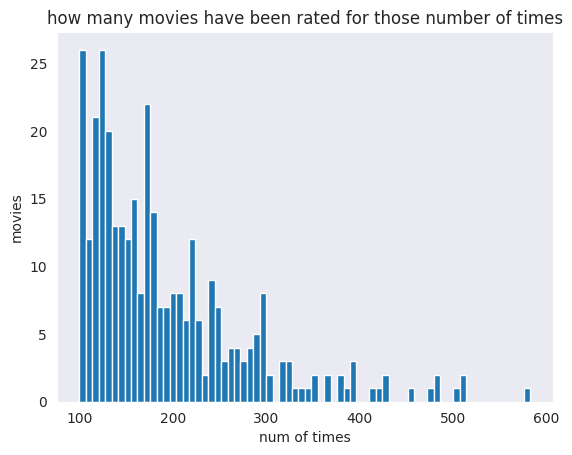

In [128]:
sns.set_style('dark')

plt.hist(ratings['num of ratings'], bins = 70)
plt.title('how many movies have been rated for those number of times')
plt.xlabel('num of times')
plt.ylabel('movies')
plt.show()

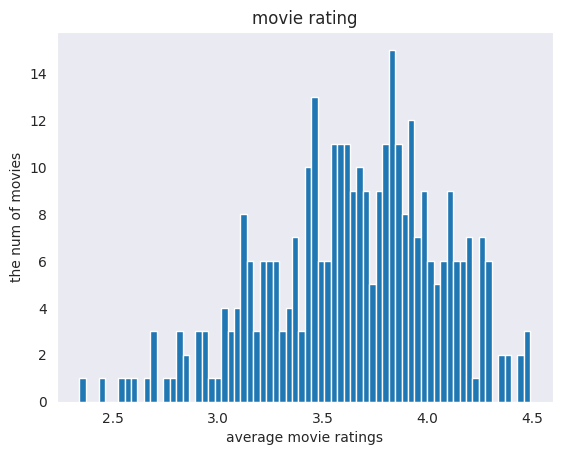

In [162]:
plt.hist(ratings['rating'], bins=70)
plt.title('movie rating')
plt.xlabel('average movie ratings')
plt.ylabel('the num of movies')
plt.show()

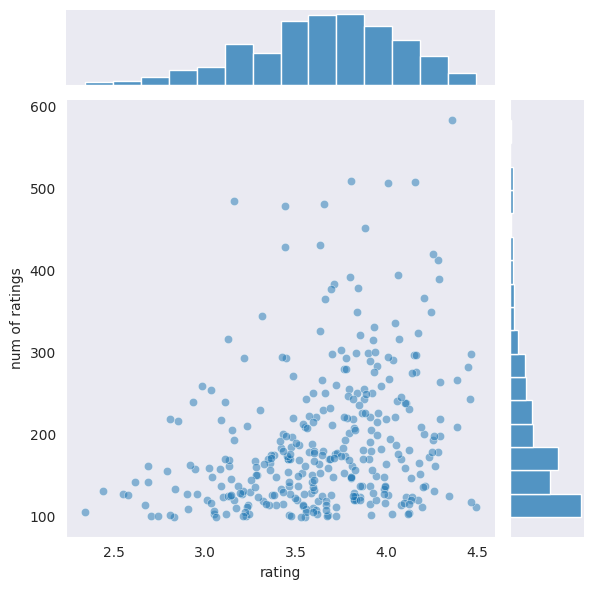

In [129]:
sns.jointplot(x='rating', y='num of ratings', data=ratings, alpha=0.5)

#### 성별 기준 비교

In [130]:
# 남녀 영화별 평점
mean_ratings = df_us.pivot_table('rating', index = 'movie_title', columns = 'gender', aggfunc = 'mean')
mean_ratings

gender,F,M
movie_title,,
'Til There Was You (1997),2.200000,2.500000
1-900 (1994),1.000000,3.000000
101 Dalmatians (1996),3.116279,2.772727
12 Angry Men (1957),4.269231,4.363636
187 (1997),3.500000,2.870968
...,...,...
Young Guns (1988),3.230769,3.204545
Young Guns II (1990),2.500000,2.800000
"Young Poisoner's Handbook, The (1995)",3.777778,3.218750


In [131]:
# 평점 개수 100개 이상인 영화만
mean_rat = mean_ratings.loc[active_titles]
mean_rat

gender,F,M
movie_title,,
101 Dalmatians (1996),3.116279,2.772727
12 Angry Men (1957),4.269231,4.363636
2001: A Space Odyssey (1968),3.491228,4.103960
Absolute Power (1997),3.451613,3.343750
"Abyss, The (1989)",3.814815,3.540323
...,...,...
Willy Wonka and the Chocolate Factory (1971),3.752688,3.583691
"Wizard of Oz, The (1939)",4.159420,4.045198
"Wrong Trousers, The (1993)",4.444444,4.472527


In [132]:
# 100개 이상 rating중 여성 상위 별점 10개
top_fem_ratings = mean_rat.sort_values(by='F', ascending=False)
top_fem_ratings.head(10)

gender,F,M
movie_title,,
Schindler's List (1993),4.632911,4.406393
"Close Shave, A (1995)",4.631579,4.462366
"Shawshank Redemption, The (1994)",4.562500,4.410959
"Wrong Trousers, The (1993)",4.444444,4.472527
Sling Blade (1996),4.411765,4.127451
Secrets & Lies (1996),4.407407,4.194444
Casablanca (1942),4.400000,4.473404
Much Ado About Nothing (1993),4.381818,3.917355
Good Will Hunting (1997),4.355932,4.223022


In [133]:
# 100개 이상 rating중 남성 상위 별점 10개
top_mal_ratings = mean_rat.sort_values(by='M', ascending=False)
top_mal_ratings.head(10)

gender,F,M
movie_title,,
Casablanca (1942),4.400000,4.473404
"Wrong Trousers, The (1993)",4.444444,4.472527
"Close Shave, A (1995)",4.631579,4.462366
"Shawshank Redemption, The (1994)",4.562500,4.410959
Schindler's List (1993),4.632911,4.406393
Rear Window (1954),4.351852,4.400000
"Usual Suspects, The (1995)",4.333333,4.399061
Star Wars (1977),4.245033,4.398148
12 Angry Men (1957),4.269231,4.363636


In [134]:
# 성별 별점 차이
mean_rat['diff'] = mean_rat['M'] - mean_rat['F']

In [135]:
# Women prefered Films
sorted_by_diff = mean_rat.sort_values(by='diff')
sorted_by_diff.head(10)

gender,F,M,diff
movie_title,,,
"First Wives Club, The (1996)",3.491525,2.742574,-0.748951
My Fair Lady (1964),4.238095,3.602410,-0.635686
Batman Forever (1995),3.173913,2.538462,-0.635452
"Net, The (1995)",3.482759,2.857143,-0.625616
Grease (1978),3.754386,3.141593,-0.612793
"Sound of Music, The (1965)",4.160000,3.564626,-0.595374
Michael (1996),3.674419,3.118421,-0.555998
Scream 2 (1997),3.629630,3.075949,-0.553680
Grumpier Old Men (1995),3.447368,2.900000,-0.547368


In [136]:
# Men prefered Films
sorted_by_diff[::-1].head(10) 
# sorted_by_diff.tail(10)과 자료는 같지만 순서가 다름

gender,F,M,diff
movie_title,,,
"Good, The Bad and The Ugly, The (1966)",3.187500,3.950413,0.762913
True Romance (1993),3.000000,3.727273,0.727273
Reservoir Dogs (1992),3.433333,4.127119,0.693785
Waterworld (1995),2.263158,2.927711,0.664553
"Bridge on the River Kwai, The (1957)",3.685714,4.307692,0.621978
2001: A Space Odyssey (1968),3.491228,4.103960,0.612732
Patton (1970),3.476190,4.086957,0.610766
Full Metal Jacket (1987),3.173913,3.761905,0.587992
Beavis and Butt-head Do America (1996),2.310345,2.897638,0.587293


#### 기타

In [147]:
# 각 유저 아이디별 movie id count
individuals = df_us.groupby(['user_id'])['movie_id'].agg({'count'})
individuals.sort_values(by='count', ascending=False)

,count
user_id,
405,737
655,685
13,636
450,540
276,518
...,...
685,20
475,20
36,20


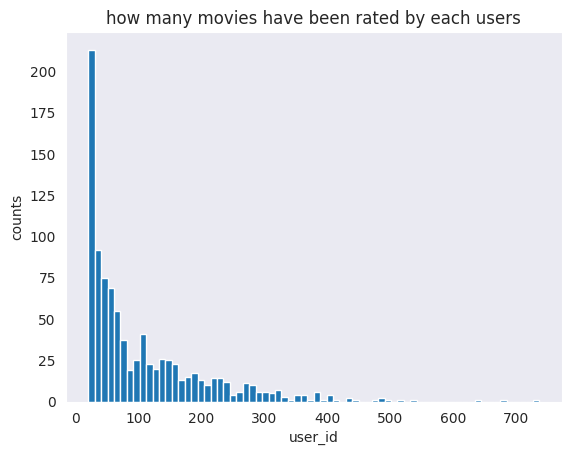

In [146]:
# 그래프
plt.hist(individuals['count'], bins = 70)
plt.title('how many movies have been rated by each users')
plt.xlabel('user_id')
plt.ylabel('counts')
plt.show()